# Distinguishing Unitary Gates on IBM Processor

Implementation of https://arxiv.org/pdf/1807.00429.pdf

In [1]:
import sys, time
sys.path.append("../")
import Qconfig
qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
print('Qconfig loaded from %s.' % Qconfig.__file__)


# Imports
import qiskit as qk
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute, register, least_busy
from qiskit.tools.visualization import plot_histogram

from qiskit import IBMQ
from qiskit import Aer

from math import pi
print(qk.__version__)

Qconfig loaded from ../Qconfig.py.
0.6.1


## Parallel Scheme

In [26]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr,cr)

In [27]:
# circuit construction

# preparing the wavefunction
qc.h(qr[0])
qc.barrier()

qc.cx(qr[0], qr[1])
qc.barrier()

qc.u3(1.2309,0,0,qr[0])
qc.barrier()

# if we apply phase shift gate
qc.u1((2.0/3)*pi,qr[0])
qc.u1((2.0/3)*pi,qr[1])
qc.barrier()

# rotating the axis for measurement
#qc.cx(qr[0],qr[1]) # THE IMPLEMENTATION PROVIDED BY THE AUTHORS SKIPS THIS CNOT APPLICATION!!! it shouldn't be
# it shouldn't be there. Improves accuracy
#qc.barrier()

qc.u3(2.1862,6.5449,pi,qr[0])
qc.u3(0.9553,2*pi,pi,qr[1])
qc.barrier()

qc.measure(qr,cr)


In [28]:
# Running locally IBM backends respond too slowly
print(Aer.backends())
backend = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)

[<QasmSimulatorPy('qasm_simulator_py') from Aer()>, <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>, <UnitarySimulator('unitary_simulator') from Aer()>]


In [29]:
job.status

<bound method AerJob.status of <qiskit.backends.aer.aerjob.AerJob object at 0x7fd4df879940>>

{'01': 510, '10': 514}


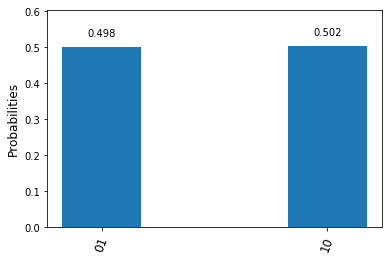

In [30]:
result = job.result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)

According to the paper 01 and 10 implies R2pi3 gate

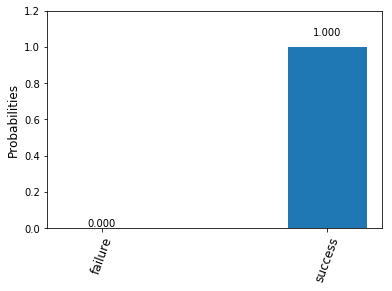

In [33]:
performance = {
    'success':(counts['01']+counts['10'])/1024,
    'failure':1 - (counts['01']+counts['10'])/1024
}

plot_histogram(performance)

Read https://arxiv.org/pdf/1712.04722.pdf to understand IBM backend architecture and coupling maps

In [34]:
IBMQ.load_accounts()

/home/vaio/Documents/Research/Quantum/btp/Playing-with-Qunatum-Computing/qpy/lib/python3.5/site-packages/qiskit/backends/ibmq/ibmqprovider.py:258: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [35]:
# checking the backends
large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] > 1 and not x.configuration()['simulator'])
print(large_enough_devices)

[<IBMQBackend('ibmqx4') from IBMQ()>, <IBMQBackend('ibmqx5') from IBMQ()>, <IBMQBackend('ibmqx2') from IBMQ()>, <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]


In [36]:
backend = IBMQ.get_backend('ibmqx4')
job = execute(qc,backend,max_credits=3)

In [39]:
job.status

<bound method IBMQJob.status of <qiskit.backends.ibmq.ibmqjob.IBMQJobPreQobj object at 0x7fd4df67ba20>>

{'01': 408, '10': 455, '00': 117, '11': 44}


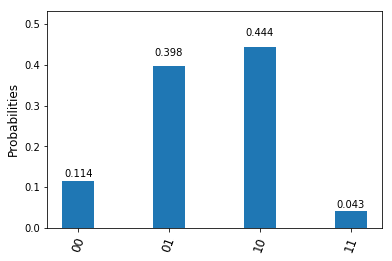

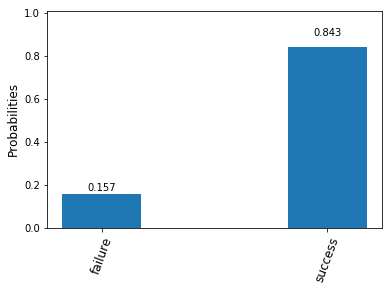

In [38]:
result = job.result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)

performance = {
    'success':(counts['01']+counts['10'])/1024,
    'failure':(counts['00']+counts['11'])/1024
}

plot_histogram(performance)

## Sequential Scheme

In [49]:
sqr = QuantumRegister(1)
scr = ClassicalRegister(1)
sqc = QuantumCircuit(sqr,scr)

In [50]:
# constructing the circuit

sqc.u3(1.1503,6.4850,2.2555,sqr[0])
sqc.barrier()

# unidentified gate -- now assumed to be R2pi3. if identity then use qc.u1(0,q[0])
sqc.u1((2.0/3)*pi,sqr[0])
sqc.barrier()

sqc.u3(1.231,0,0,sqr[0])   # X
sqc.barrier()

sqc.u1((2.0/3)*pi,sqr[0]) # U (unidentified gate)
sqc.barrier()

# measurement
sqc.u3(0.7854,6.0214,6.1913,sqr[0])
sqc.barrier()

sqc.measure(sqr,scr)

{'1': 3, '0': 1021}


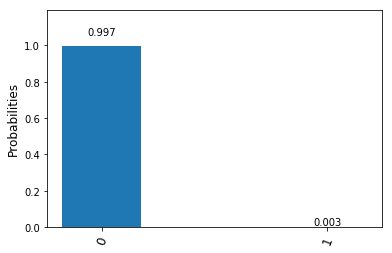

In [51]:
# Running on local simulator
backend = Aer.get_backend('qasm_simulator')
job = execute(sqc,backend)
result = job.result()
counts = result.get_counts(sqc)
print(counts)

plot_histogram(counts)

According to the paper 0 implies R2pi3

{'1': 41, '0': 983}


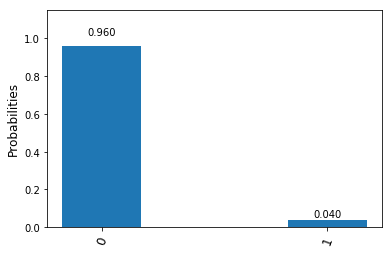

In [52]:
# Running on IBM
backend = IBMQ.get_backend('ibmqx4')
job = execute(sqc,backend,max_credits=3)

result = job.result()
counts = result.get_counts(sqc)
print(counts)

plot_histogram(counts)